In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df_calls = pd.read_csv('/datasets/megaline_calls.csv')

In [4]:
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [5]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [6]:
df_internet = pd.read_csv('/datasets/megaline_internet.csv')

In [7]:
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [8]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [9]:
df_messages = pd.read_csv('/datasets/megaline_messages.csv')

In [10]:
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [11]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [12]:
df_tarrifs = pd.read_csv('/datasets/megaline_tariffs.csv')

In [13]:
df_tarrifs

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,tariff_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [14]:
df_users = pd.read_csv('/datasets/megaline_users.csv')

In [15]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Now I will start data preprocessing.

first lets transform date columns into datetime format wherewer possible.

In [17]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])

In [18]:
df_messages['message_date'] =  pd.to_datetime(df_messages['message_date'])

In [19]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

In [20]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

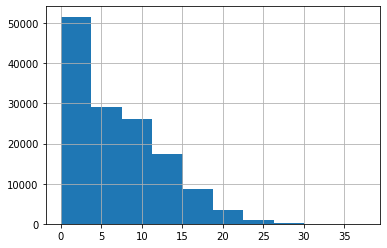

In [21]:
df_calls['duration'].hist();

In [22]:
df_calls.duplicated().sum()

0

In [23]:
df_users.duplicated().sum()

0

In [24]:
df_internet.duplicated().sum()

0

In [25]:
df_messages.duplicated().sum()

0

In [26]:
df_users.duplicated().sum()

0

a lot of calls has duration of 0 I think this is just because the user is inactive and I will keep the data as it is for now.

No duplicate values found, don't really understand which values might be invalid and by what criteria.

Now lets find stuff for each user and make a new dataframe with all the stuff.

In [27]:
user_calls = df_calls.groupby('user_id',as_index=False).agg({'duration': ['sum', 'count']})

In [28]:
user_messages = df_messages.groupby('user_id',as_index=False)['message_date'].count()

In [29]:
user_messages.columns = ['user_id','messages_sent']

In [30]:
user_internet = df_internet.groupby('user_id',as_index=False)['mb_used'].sum()

In [31]:
df = pd.merge(user_calls,user_messages,left_on='user_id',right_on='user_id')

In [32]:
df.drop(df.columns[1],axis=1,inplace=True)

In [33]:
df = pd.merge(df,user_internet,on='user_id')

In [34]:
df['plan'] = df_users['tariff']

now we have a dataframe with all the usage by each user, now lets calculate profit from each user

Rounding up the calls duration and MB used

In [35]:
df.columns = ['user_id','call_duration','call_count','messages_sent','mb_used','plan']

In [36]:
df['call_duration'] = df['call_duration'].apply(np.ceil)
df['mb_used']=df['mb_used'].apply(np.ceil)

In [37]:
df['gb_used'] = df['mb_used'] / 1024

In [38]:
def over_minutes(row):
    if row['plan'] == 'ultimate':
        return row['call_duration'] - 3000
    else:
        return row['call_duration'] - 500

In [39]:
df['minutes_over'] = df.apply(over_minutes,axis=1)

In [40]:
def over_messages(row):
    if row['plan'] == 'ultimate':
        return row['messages_sent'] - 1000
    else:
        return row['messages_sent'] - 50

In [41]:
df['messages_over'] = df.apply(over_messages,axis=1)

In [42]:
def over_internet(row):
    if row['plan'] == 'ultimate':
        return row['gb_used'] - 30
    else:
        return row['gb_used'] - 15

In [43]:
df['gb_over'] = df.apply(over_internet,axis=1)

In [44]:
df.loc[df['gb_over'] <0, 'gb_over'] = 0
df.loc[df['minutes_over'] <0, 'minutes_over'] = 0
df.loc[df['messages_over'] <0, 'messages_over'] = 0


In [45]:
def calc_profit(row):
    if row['plan'] == 'ultimate':
        return 70+row['gb_over']*7+row['minutes_over'] * 0.01 + row['messages_over'] * 0.01
    else:
        return 20+row['gb_over']*10+row['minutes_over'] * 0.03 + row['messages_over'] * 0.03

In [46]:
df['profit_usd'] = df.apply(calc_profit,axis=1)

now that our database is ready lets start working on step 3 and analyze the data

In [47]:
df.head()

,user_id,call_duration,call_count,messages_sent,mb_used,plan,gb_used,minutes_over,messages_over,gb_over,profit_usd
0,1000,117.0,16,11,1902.0,ultimate,1.857422,0.0,0,0.000000,70.000000
1,1001,1641.0,261,207,80438.0,surf,78.552734,1141.0,157,63.552734,694.467344
2,1002,778.0,113,88,40294.0,surf,39.349609,278.0,38,24.349609,272.976094
3,1003,1041.0,149,50,27045.0,surf,26.411133,541.0,0,11.411133,150.341328
4,1004,2619.0,370,177,156353.0,surf,152.688477,2119.0,127,137.688477,1464.264766


In [48]:
t=df.groupby('plan',as_index=False)['call_duration','messages_sent','gb_used'].agg(['sum','mean','var','std'])

In [49]:
t

call_duration                                         messages_sent  \
                   sum         mean           var          std           sum   
plan                                                                           
surf          508293.0  1861.879121  2.557833e+06  1599.322709         51003   
ultimate      234853.0  1957.108333  2.839529e+06  1685.090321         22597   

                                                     gb_used             \
                mean           var         std           sum       mean   
plan                                                                      
surf      186.824176  35631.755737  188.763756  19459.886719  71.281636   
ultimate  188.308333  36238.601611  190.364392   9649.485352  80.412378   

                                  
                  var        std  
plan                              
surf      3229.929952  56.832473  
ultimate  3960.855735  62.935330

On this table we can see that on average surf plan members use less minutes, less messages and less internet, however the difference is not that huge.

In [50]:
f = df[df['plan']=='surf']

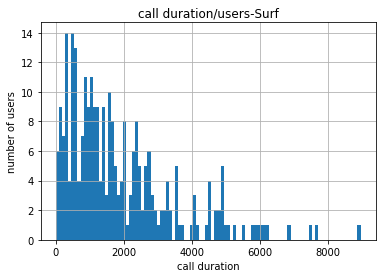

In [51]:
f['call_duration'].hist(bins=100);
plt.title('call duration/users-Surf');
plt.xlabel('call duration');
plt.ylabel('number of users');

the call duration distribution in the surf plan is positively skewed, has a mean of 1861.365311 and a couple of outliers towards the end.

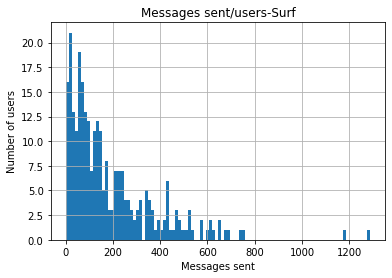

In [52]:
f['messages_sent'].hist(bins=100);
plt.title('Messages sent/users-Surf');
plt.xlabel('Messages sent');
plt.ylabel('Number of users');

The messages distribution in the surf plan is positively skewed has a mean of 186.824176 and a couple of outliers towards the end

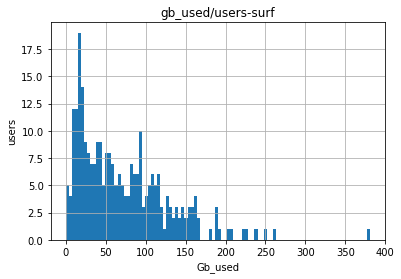

In [53]:
f['gb_used'].hist(bins = 100);
plt.title('gb_used/users-surf');
plt.xlabel('Gb_used');
plt.ylabel('users');

The internet used distribution in the surf plan is positively skewed has a mean of 71.281143 and a on outlier at the end

In [54]:
ff = df[df['plan']=='ultimate']

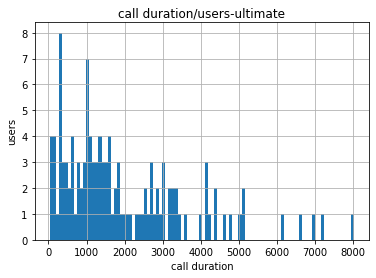

In [55]:
ff['call_duration'].hist(bins=100);
plt.title('call duration/users-ultimate');
plt.xlabel('call duration');
plt.ylabel('users');

the call duration distribution in the ultimate plan is multimodal, has a mean of 1956.591750 and a couple of outliers towards the end.

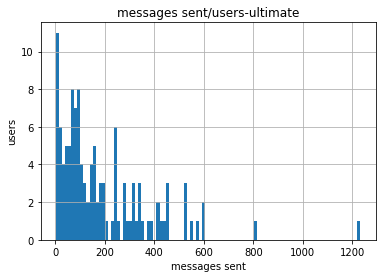

In [56]:
ff['messages_sent'].hist(bins=100);
plt.title('messages sent/users-ultimate');
plt.xlabel('messages sent');
plt.ylabel('users');

The messages distribution in the ultimate plan is positively skewed has a mean of 188.308333 and a couple of outliers towards the end.

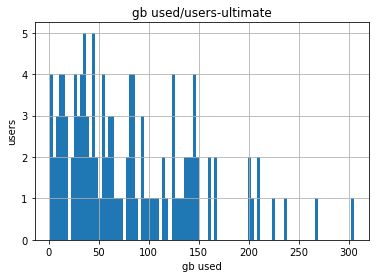

In [57]:
ff['gb_used'].hist(bins = 100);
plt.title('gb used/users-ultimate');
plt.xlabel('gb used');
plt.ylabel('users');

The internet used distribution in theultimate plan has a multimodal shape has a mean of 80.411914 and a couple of outliers at the end

from looking at all of this data I can make a conclujsion that it does not really matter which plan you chose because ultimately people from poth plans use the same amount messages, calls and traffic on average

Now lets go into step 4 and test some hypothesys

The first null hypothesis is 'The company earns different amounts from the Ultimate and Surf plans (measured in terms of average monthly revenue)' to test this lets first calculate exactly how much the company earns on average from each person and also how many people there are in each plan

In [58]:
ff = df.groupby('plan')['profit_usd'].agg(['mean','std','var'])

In [59]:
df['plan'].value_counts()

surf        273
ultimate    120
Name: plan, dtype: int64

In [60]:
ff

,mean,std,var
plan,,,
surf,635.820857,597.477608,356979.491995
ultimate,450.370965,420.894243,177151.963658


using the two sample t-test https://www.evanmiller.org/ab-testing/t-test.html#!640.18348/597.877767/273;452.990667/421.705318/120@95 I concluded that company earns more money from the surf plan members on average

Lets correct the first hypothesis first. As you said the null hypothesis will be "The company earns equal amounts from the Ultimate and Surf plans on average". variances are significantely different..

In [61]:
x = df[df['plan']=='ultimate']['profit_usd']
y = df[df['plan']=='surf']['profit_usd']

In [62]:
stats.ttest_ind(x,y,equal_var = False)

Ttest_indResult(statistic=-3.5148035225283296, pvalue=0.0005045916850827033)

The p value is 0.0005 thus we can reject the hypothesis. Thus they dont earn equal amounts from Ultimate and Surf plans on average. So they earn more from surf because the mean is greater

Now lets work on the second hypotheses: Average monthly revenue from users in the NY-NJ area differs from that in other regions. To calculate this lets first add a column to our dataframe with the information about if the user is from NJ/NY area.

In [63]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [64]:
def isinnynj(row):
    if 'NY' in row['city'] :
        return True
    elif 'NJ' in row['city']:
        return True
    else:
        return False

In [65]:
df_users['is_in_NYNJ'] = df_users.apply(isinnynj,axis=1)

In [66]:
df['is_in_NYNJ'] = df_users['is_in_NYNJ']

In this case the null hypothesis will be "Average revenue from users in NY-NJ area is equal to the other regions revenue".

In [67]:
fr = df.groupby('is_in_NYNJ')['profit_usd'].agg(['mean','std','count','var'])

In [68]:
fr

,mean,std,count,var
is_in_NYNJ,,,,
False,558.776547,563.556388,309,317595.802315
True,654.305437,522.091792,84,272579.839218


variances are different. Now lets perform the T-Test

In [69]:
x = df[df['is_in_NYNJ'] == True]['profit_usd']
y = df[df['is_in_NYNJ'] == False]['profit_usd']

In [70]:
stats.ttest_ind(x,y,equal_var = False)

Ttest_indResult(statistic=1.4614286738583309, pvalue=0.14613683843780725)

The p-value for the test is 0.14613683843780725 which is quite high thus I can not reject the null hypothesys and thus the average revenue in the regions is the same.

**Final Conclusion**

In this project I explored the datasets and calculated the profit from each user for the company. Then I analyzed the client behavior from each plan and looked at the internet traffic, messages sent and call duration. I concluded that it does not really matter which plan you chose because ultimately people from poth plans use the same amount messages, calls and traffic on average, because graphs looked similar. My conclusion is strengthened because from the first hypothesis I concluded that the company earns more money from the surf plan members which is cheaper but has higher rates. After that I looked at the average revenue for the company from NY-NJ area and other regions and using the two sided t-test I could not reject the null hypothesys and concluded that on average the revenues are the same.